# XPCS fitting with lmfit
The experimentatl X-ray Photon Correlation Sepectroscopy(XPCS) data
are fitted with Intermediate Scattering Factor(ISF) using
lmfit Model (http://lmfit.github.io/lmfit-py/model.html)

In [1]:
# analysis tools from scikit-beam (https://github.com/scikit-beam/scikit-beam/tree/master/skbeam/core)
import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

from lmfit import Model

# plotting tools from xray_vision (https://github.com/Nikea/xray-vision/blob/master/xray_vision/mpl_plotting/roi.py)
import xray_vision.mpl_plotting as mpl_plot  

import numpy as np
import os, sys
import zipfile

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Easily switch between interactive and static matplotlib plots

In [2]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

##  This data provided by Dr. Andrei Fluerasu
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini, C. Carona and A. Fluerasu ,
"Photon statistics and speckle visibility spectroscopy with partially coherent x-rays"
J. Synchrotron Rad., vol 21, p 1288-1295, 2014.

In [3]:
%run download.py

__file__
current_folder = /Volumes/Data/All_NSLS2/scikit-beam-examples/demos/time_correlation
current_folder = /Volumes/Data/All_NSLS2/scikit-beam-examples/demos/time_correlation


In [4]:
data_dir = "Duke_data/"
duke_rdata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_rdata.shape[0]):
    duke_data.append(duke_rdata[i] - duke_dark)
    
duke_ndata=np.asarray(duke_data)

# load the mask(s) and mask the data
mask1 = np.load(data_dir+"new_mask4.npy")
mask2 = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask1 + mask2)

In [5]:
mask_data = N_mask*duke_ndata

/Users/sameera/mc/envs/work/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


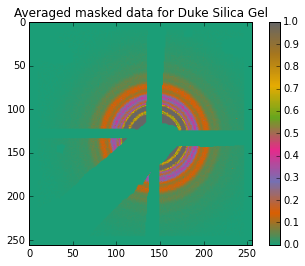

In [6]:
#  get the average image
avg_img = np.average(duke_ndata, axis=0)

# if matplotlib version 1.5 or later
if float('.'.join(mpl.__version__.split('.')[:2])) >= 1.5:
    cmap = 'viridis'
else:
    cmap = 'Dark2'

# plot the average image data after masking
plt.figure()
plt.imshow(N_mask*avg_img, vmax=1e0, cmap= cmap )
plt.title("Averaged masked data for Duke Silica Gel ")
plt.colorbar()
plt.show()

## Create the Rings Mask 
Use the skbeam.core.roi module to create Ring ROIs (ROI Mask)¶ (https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/roi.py)

In [7]:
inner_radius = 24  # radius of the first ring
width = 1        # width of each ring
spacing = 0      # no spacing between rings
num_rings = 5    # number of rings
center = (133, 143)   # center of the spckle pattern

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 24.,  25.],
       [ 25.,  26.],
       [ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.]])

###Convert the edge values of the rings to q ( reciprocal space)

In [8]:
dpix = 0.055  # The physical size of the pixels

lambda_ = 1.5498  # wavelength of the X-rays
Ldet = 2200.   #   # detector to sample distance

two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_val = utils.twotheta_to_q(two_theta, lambda_)

q_val

array([[ 0.00243251,  0.00253387],
       [ 0.00253387,  0.00263522],
       [ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929]])

In [9]:
q_ring = np.mean(q_val, axis=1)
q_ring

array([ 0.00248319,  0.00258455,  0.0026859 ,  0.00278726,  0.00288861])

## Create a labeled array using roi.rings

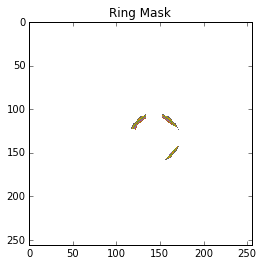

In [10]:
rings = roi.rings(edges, center, avg_img.shape)

mask_data2 = N_mask*duke_data[0:4999]

ring_mask = rings*N_mask

# plot the figure
fig, axes = plt.subplots()
axes.set_title("Ring Mask")
im = mpl_plot.show_label_array(axes, ring_mask, cmap="Dark2")
plt.show()


## Find the experimental auto correlation functions

Use the skbeam.core.correlation module (https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py)

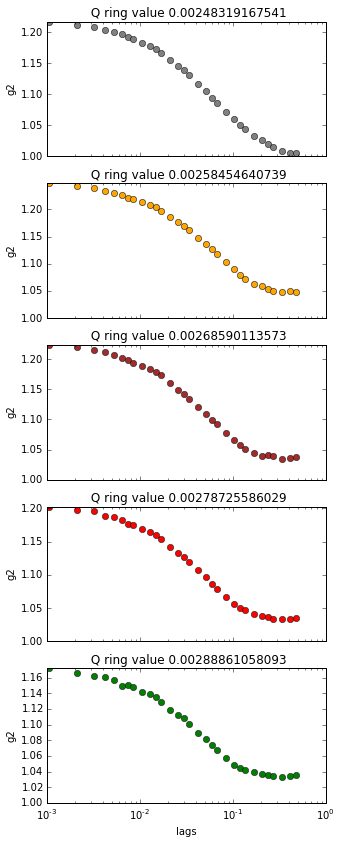

In [11]:
num_levels = 7
num_bufs = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, ring_mask,
                                             mask_data2)

exposuretime=0.001;
deadtime=60e-6;
timeperframe = exposuretime+deadtime
lags = lag_steps*timeperframe

roi_names = ['gray', 'orange', 'brown', 'red', 'green']


fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5, 14))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].set_title(" Q ring value " + str(q_ring[i]))
    axes[i].semilogx(lags, g2[:, i], 'o', markerfacecolor=roi_color, markersize=6)
    axes[i].set_ylim(bottom=1, top=np.max(g2[1:, i]))
plt.show()

## Do the fitting

One time correlation data is fitted using the model in skbeam.core.correlation module
(auto_corr_scat_factor)
(https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py)

In [12]:
mod = Model(corr.auto_corr_scat_factor)

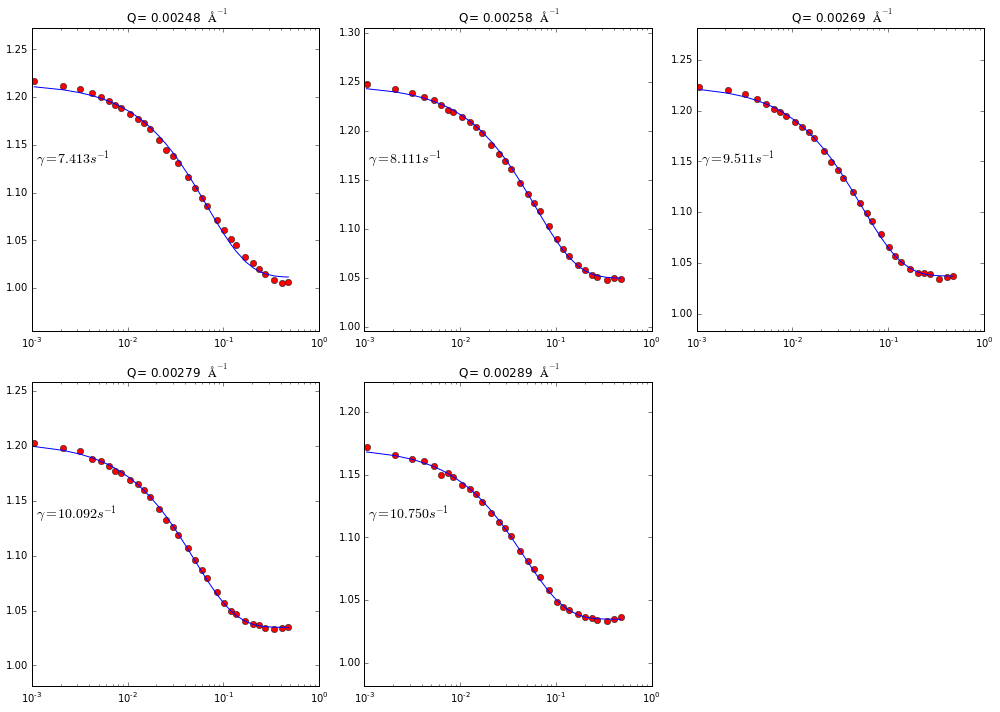

In [13]:
rate = []  #  relaxation rate

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure(figsize=(14, 10))
plt.title('Duke Silica Gel', fontsize=20, y =1.02) 
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    y=g2[1:, i]
    result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
    rate.append(result1.best_values['relaxation_rate'])
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring[i]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rate[i]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
fig.tight_layout()  
plt.show()


In [14]:
rate

[7.4131044419308694,
 8.1106248354078545,
 9.5111079963065421,
 10.092087480040846,
 10.750058581371231]

In [15]:
result1.best_values

{'baseline': 1.0346573587509935,
 'beta': 0.13659002147645355,
 'relaxation_rate': 10.750058581371231}

## Plot the relaxation rates vs (q_ring_center)**2

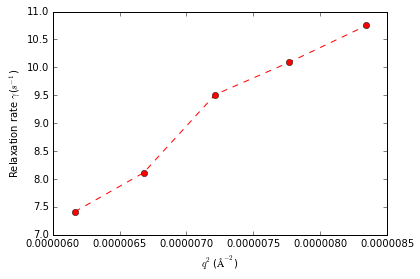

In [16]:
fig, ax = plt.subplots()
ax.plot(q_ring**2, rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## Fitted the Diffusion Coefficinet D0

In [17]:
D0 = np.polyfit(q_ring**2, rate, 1)
gmfit = np.poly1d(D0)
D0[0] # (Angstroms)^(-2)

1585819.3173357171

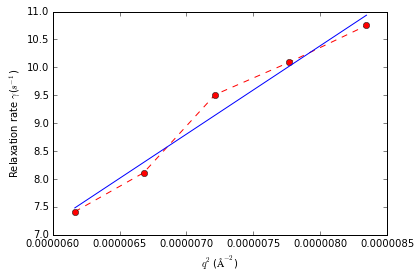

In [18]:
fig, ax = plt.subplots()
ax.plot(q_ring**2, rate, 'ro', ls='--')
ax.plot(q_ring**2,  gmfit(q_ring**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

In [19]:
import skbeam
print(skbeam.__version__)

0.0.6+34.g73ae7f1
